[epoch 0]
train free energy:149.10372924804688
test free energy:121.4621353149414
[epoch 1]
train free energy:117.45803833007812
test free energy:113.42265319824219
[epoch 2]
train free energy:112.4206771850586
test free energy:110.44292449951172
[epoch 3]
train free energy:110.19654846191406
test free energy:109.17549896240234
[epoch 4]
train free energy:108.85308074951172
test free energy:107.58270263671875
[epoch 5]
train free energy:108.00151062011719
test free energy:107.10803985595703
[epoch 6]
train free energy:107.4185562133789
test free energy:106.59954833984375
[epoch 7]
train free energy:106.84676361083984
test free energy:106.36174011230469
[epoch 8]
train free energy:106.42578125
test free energy:106.16754913330078
[epoch 9]
train free energy:105.98175048828125
test free energy:105.7406997680664
[epoch 10]
train free energy:105.67454528808594
test free energy:105.4609375
[epoch 11]
train free energy:105.41123962402344
test free energy:104.73784637451172
[epoch 12]
train fr

(array([  90.,  100.,  110.,  120.,  130.,  140.,  150.]),
 <a list of 7 Text yticklabel objects>)

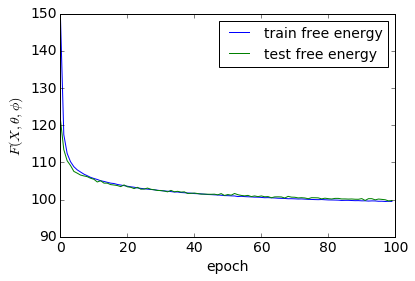

In [1]:
%matplotlib inline
from chainer import FunctionSet,Variable
import chainer.functions as F
import numpy
import numpy as np
import pdb
from chainer import cuda



xp = cuda.cupy
num_epochs = 100

class VAE_gaussian(FunctionSet):

    # You must add attr named with 'enc_l1' and 'dec_l1'
    # for specification of the input and latent dimensions, in __init__ of FunctionSet.

    def encode(self,x):
        raise NotImplementedError()

    def decode(self,z):
        raise NotImplementedError()

    def free_energy(self,x):
        #return -(free energy)
        enc_mu, enc_log_sigma_2 = self.encode(x)
        kl = F.gaussian_kl_divergence(enc_mu,enc_log_sigma_2)
        z = F.gaussian(enc_mu,enc_log_sigma_2)
        dec_mu, dec_log_sigma_2 = self.decode(z)
        nll = F.gaussian_nll(x,dec_mu,dec_log_sigma_2)
        return nll+kl

    def generate(self,N,sampling_x=False):
        z_dim = self['dec_l1'].W.shape[1]
        if(isinstance(self['dec_l1'].W,xp.ndarray)):
            zero_mat = Variable(xp.zeros((N,z_dim),'float32'))
            z = F.gaussian(zero_mat,zero_mat)
        else:
            raise NotImplementedError()
        dec_mu, dec_log_sigma_2 = self.decode(z)
        if(sampling_x):
            x = F.gaussian(dec_mu,dec_log_sigma_2)
        else:
            x = dec_mu
        return x

    def reconstruct(self,x):
        enc_mu, enc_log_sigma_2 = self.encode(x)
        dec_mu, dec_log_sigma_2 = self.decode(enc_mu)
        return dec_mu

class VAE_bernoulli(VAE_gaussian):

    def free_energy(self,x):
        #return -(free energy)
        enc_mu, enc_log_sigma_2 = self.encode(x)
        kl = F.gaussian_kl_divergence(enc_mu,enc_log_sigma_2)
        z = F.gaussian(enc_mu,enc_log_sigma_2)
        dec_mu = self.decode(z)
        nll = F.bernoulli_nll(x,dec_mu)
        return nll+kl

    def generate(self,N,sampling_x=False):
        z_dim = self['dec_l1'].W.shape[1]
        if(isinstance(self['dec_l1'].W.data,xp.ndarray)):
            zero_mat = Variable(xp.zeros((N,z_dim),'float32'))
            z = F.gaussian(zero_mat,zero_mat)
        else:
            raise NotImplementedError()

        dec_mu = F.sigmoid(self.decode(z))
        if(sampling_x):
            raise NotImplementedError()
        else:
            x = dec_mu
        return x


    def reconstruct(self,x):
        enc_mu, enc_log_sigma_2 = self.encode(x)
        dec_mu = F.sigmoid(self.decode(enc_mu))
        return dec_mu


from chainer import FunctionSet,Variable,serializers
import chainer.functions as F
import numpy


class VAE_MNIST(VAE_gaussian):
    def __init__(self):
        super(VAE_MNIST,self).__init__(
            enc_l1 = F.Linear(784,500),
            enc_l_mu = F.Linear(500,30),
            enc_l_log_sig_2 = F.Linear(500,30),
            dec_l1 = F.Linear(30,500),
            dec_l_mu = F.Linear(500,784),
            dec_l_log_sig_2 = F.Linear(500,784))

    def encode(self,x):
        h = x
        h = self.enc_l1(h)
        h = F.relu(h)
        return self.enc_l_mu(h),self.enc_l_log_sig_2(h)

    def decode(self,z):
        h = z
        h = self.dec_l1(h)
        h = F.relu(h)
        return self.dec_l_mu(h),self.dec_l_log_sig_2(h)

class VAE_MNIST_b(VAE_bernoulli):
    def __init__(self):
        super(VAE_MNIST_b,self).__init__(
            enc_l1 = F.Linear(784,500),
            enc_l2 = F.Linear(500,500),
            enc_l_mu = F.Linear(500,30),
            enc_l_log_sig_2 = F.Linear(500,30),
            dec_l1 = F.Linear(30,500),
            dec_l2 = F.Linear(500,500),
            dec_l_mu = F.Linear(500,784))

    def encode(self,x):
        h = x
        h = self.enc_l1(h)
        h = F.relu(h)
        h = self.enc_l2(h)
        h = F.relu(h)
        return self.enc_l_mu(h),self.enc_l_log_sig_2(h)
    
    def decode(self,z):
        h = z
        h = self.dec_l1(h)
        h = F.relu(h)
        h = self.dec_l2(h)
        return self.dec_l_mu(h)
    

from chainer import FunctionSet,Variable

import chainer.functions as F
import chainer.optimizers as optimizers
import numpy
import matplotlib.pyplot as plt

vae = VAE_MNIST_b()
cuda.get_device(0).use()
vae.to_gpu()
optimizer = optimizers.Adam(alpha=0.001)
optimizer.setup(vae)

from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
x_all = mnist.data.astype(xp.float32)/255
#y_all = mnist.target.astype(xp.int32)
x_train, x_test = xp.split(x_all, [60000])
#y_train, y_test = xp.split(y_all, [60000])



train_free_energies = xp.zeros(num_epochs)
test_free_energies = xp.zeros(num_epochs)

batchsize = 100
for epoch in range(num_epochs):
    indexes = np.random.permutation(60000)
    n_batch = indexes.shape[0]/batchsize
    sum_free_energy = 0

    for i in range(0, 60000, batchsize):
        x_batch = Variable(xp.asarray(x_train[indexes[i : i + batchsize]]))
        free_energy = vae.free_energy(x_batch)
        
        #print(free_energy.data)
        sum_free_energy += free_energy.data
        optimizer.zero_grads()
        free_energy.backward()
        optimizer.update()
    
    indexes = np.random.permutation(10000)   
    sum_test_free_energy = 0
    for i in range(0, 10000, batchsize):
        x_batch = Variable(xp.asarray(x_test[indexes[i : i + batchsize]]))
        free_energy = vae.free_energy(x_batch)
        sum_test_free_energy += free_energy.data

    train_free_energies[epoch] = sum_free_energy/60000
    test_free_energies[epoch] = sum_test_free_energy/10000
         
    print( '[epoch ' +  str(epoch) +']')
    print ('train free energy:' + str(train_free_energies[epoch]))
    print ('test free energy:' + str(test_free_energies[epoch]))

fontsize = 14
plt.plot(np.arange(0,num_epochs),cuda.to_cpu(train_free_energies),label='train free energy')
plt.plot(np.arange(0,num_epochs),cuda.to_cpu(test_free_energies),label='test free energy')
plt.legend(fontsize=fontsize)
plt.xlabel('epoch',fontsize=fontsize)
plt.ylabel('$F(X,\\theta,\phi)$',fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
#plt.show()

In [2]:

'''serializers.load_npz('my.model', vae)
serializers.load_npz('my.state', optimizer)
'''

"serializers.load_npz('my.model', vae)\nserializers.load_npz('my.state', optimizer)\n"

In [3]:
'''
serializers.save_npz('my.model', vae)
serializers.save_npz('my.state', optimizer)
'''

"\nserializers.save_npz('my.model', vae)\nserializers.save_npz('my.state', optimizer)\n"

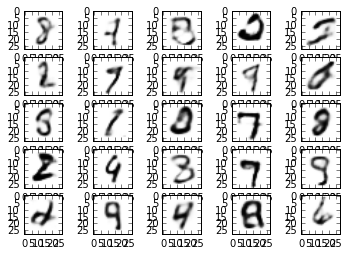

In [4]:
x_samples = vae.generate(10000,False)
plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(cuda.to_cpu(x_samples.data[i].reshape(28,28)),'binary')
plt.show()

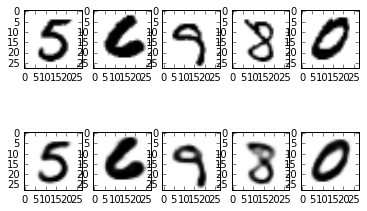

In [5]:
indexes = np.random.permutation(10000)   
x_batch = Variable(xp.asarray(x_test[indexes[:10]]))
x_recon = vae.reconstruct(x_batch)
plt.figure()
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(cuda.to_cpu(x_batch.data[i].reshape(28,28)),'binary')
for i in range(5):
    plt.subplot(2,5,i+6)
    plt.imshow(cuda.to_cpu(x_recon.data[i].reshape(28,28)),'binary')
plt.show()

In [6]:
# 確率的勾配降下法で学習させる際の１回分のバッチサイズ
batchsize = 100

# 学習の繰り返し回数
n_epoch   = 20

# 中間層の数
n_units   = 1000

# 表示するdigit数(n*10)
n_show = 20

print ('fetch MNIST dataset')
mnist = fetch_mldata('MNIST original')
mnist.data   = mnist.data.astype(xp.float32)
mnist.data  /= 255  
mnist.target = mnist.target.astype(xp.int32)

# 学習用データを N個、検証用データを残りの個数と設定
N = 60000
x_train, x_test = xp.split(mnist.data,   [N])
y_train, y_test = xp.split(mnist.target, [N])
N_test = y_test.size

model = FunctionSet(l1=F.Linear(784, n_units),
                    l2=F.Linear(n_units, n_units),
                    l3=F.Linear(n_units, 10))

def forward(x_data, y_data, train=True):
    x, t = Variable(x_data), Variable(y_data)
    h1 = F.dropout(F.relu(model.l1(x)),  train=train)
    h2 = F.dropout(F.relu(model.l2(h1)), train=train)
    y  = model.l3(h2)
    
    y_prob = F.softmax(y)
    entropy = - F.sum((F.log2(y_prob) * y_prob))
    if train:
        return F.softmax_cross_entropy(y, t), F.accuracy(y, t)
    if not train:
        return entropy

cuda.get_device(0).use()
model.to_gpu()
optimizer2 = optimizers.Adam()
optimizer2.setup(model)

train_loss = []
train_acc  = []
test_loss = []
test_acc  = []

# Learning loop
for epoch in range(1, n_epoch+1):
    print ('epoch', epoch)

    perm = np.random.permutation(N)
    sum_accuracy = 0
    sum_loss = 0
    for i in range(0, N, batchsize):
        x_batch = xp.asarray(x_train[perm[i:i+batchsize]])
        y_batch = xp.asarray(y_train[perm[i:i+batchsize]])

        optimizer2.zero_grads()
        loss, acc = forward(x_batch, y_batch)
        loss.backward()
        optimizer2.update()

        train_loss.append(loss.data)
        train_acc.append(acc.data)
        sum_loss     += float(cuda.to_cpu(loss.data)) * batchsize
        sum_accuracy += float(cuda.to_cpu(acc.data)) * batchsize

    print ('train mean loss={}, accuracy={}'.format(sum_loss / N, sum_accuracy / N))

fetch MNIST dataset
epoch 1
train mean loss=0.2826193772380551, accuracy=0.9128500012680888
epoch 2
train mean loss=0.13721133881869416, accuracy=0.9581166689594587
epoch 3
train mean loss=0.10801571592222899, accuracy=0.9670833384990692
epoch 4
train mean loss=0.09384859066766997, accuracy=0.9704833416144053
epoch 5
train mean loss=0.0839303856017068, accuracy=0.9744000083208084
epoch 6
train mean loss=0.07714138673540825, accuracy=0.9762333430846533
epoch 7
train mean loss=0.0709293901163619, accuracy=0.9777000105381012
epoch 8
train mean loss=0.06441537369605309, accuracy=0.9799000108242035
epoch 9
train mean loss=0.06136953940576253, accuracy=0.9808666758735974
epoch 10
train mean loss=0.06292614479937281, accuracy=0.9809166771173478
epoch 11
train mean loss=0.05757825935395279, accuracy=0.9819666776061058
epoch 12
train mean loss=0.053559701740353675, accuracy=0.9834000103672346
epoch 13
train mean loss=0.05319033024449406, accuracy=0.9836833448211352
epoch 14
train mean loss=0.05

In [7]:
'''
serializers.load_npz('my.model_mnist', model)
serializers.load_npz('my.state_mnist', optimizer2)
'''

"\nserializers.load_npz('my.model_mnist', model)\nserializers.load_npz('my.state_mnist', optimizer2)\n"

In [8]:
'''
serializers.save_npz('my.model_mnist', model)
serializers.save_npz('my.state_mnist', optimizer2)
'''

"\nserializers.save_npz('my.model_mnist', model)\nserializers.save_npz('my.state_mnist', optimizer2)\n"

calculating entropy


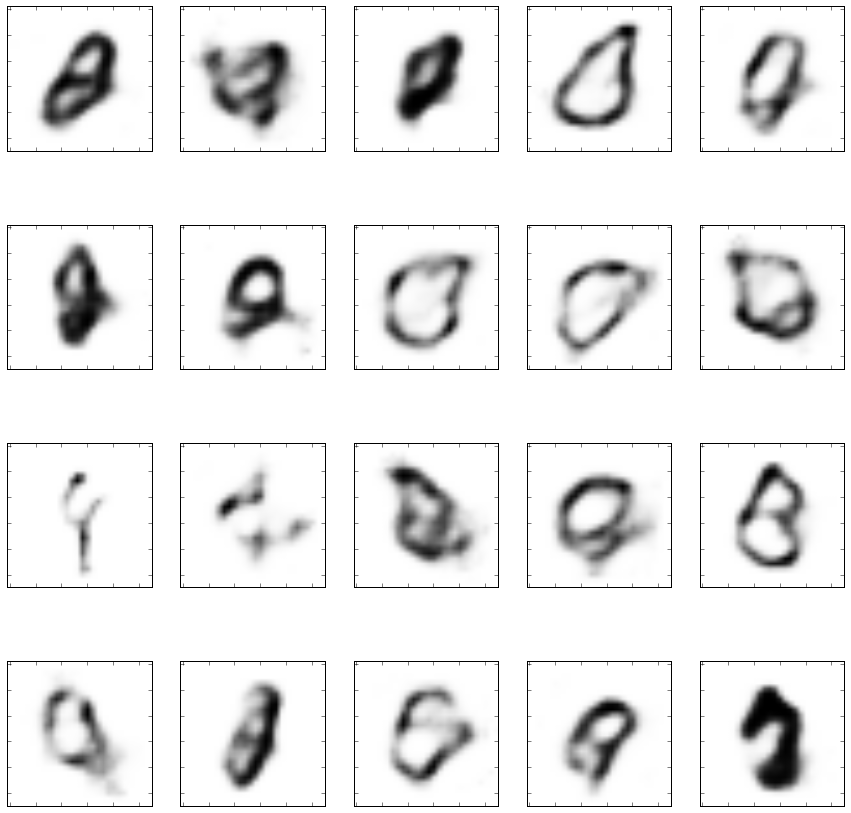

In [9]:
print('calculating entropy')
entropy_list = xp.zeros(10000)
x_test_samples = x_samples.data
batchsize = 1
for i in range(0, 10000, batchsize):
    x_batch = xp.asarray(x_test_samples[i:i+batchsize])
    y_batch = xp.asarray(y_test[i:i+batchsize])
    entropy = forward(x_batch, y_batch, train=False)
    entropy_list[i] = entropy.data
entropy_list = np.nan_to_num(cuda.to_cpu(entropy_list))   
entropy_list2 = np.sort(cuda.to_cpu(entropy_list))[::-1]
entropy_list3 = np.sort(cuda.to_cpu(entropy_list))
max_entropy = entropy_list2[0:n_show]
min_entropy = entropy_list3[0:n_show]
index_list = np.zeros(n_show,dtype=np.int64)
index_list2 = np.zeros(n_show,dtype=np.int64)


for j in range(n_show):
    index = np.where(cuda.to_cpu(entropy_list) == max_entropy[j])
    #pdb.set_trace()
    index_list[j] = index[0][0]
    
    index = np.where(cuda.to_cpu(entropy_list) == min_entropy[j])
    index_list2[j] = index[0][0]

    

plt.figure(figsize=(15,15))
for i in range(n_show):
    ind = index_list[i]
    plt.subplot(n_show/5,5,i+1)
    plt.imshow(cuda.to_cpu(x_test_samples[ind].reshape(28,28)),'binary')
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

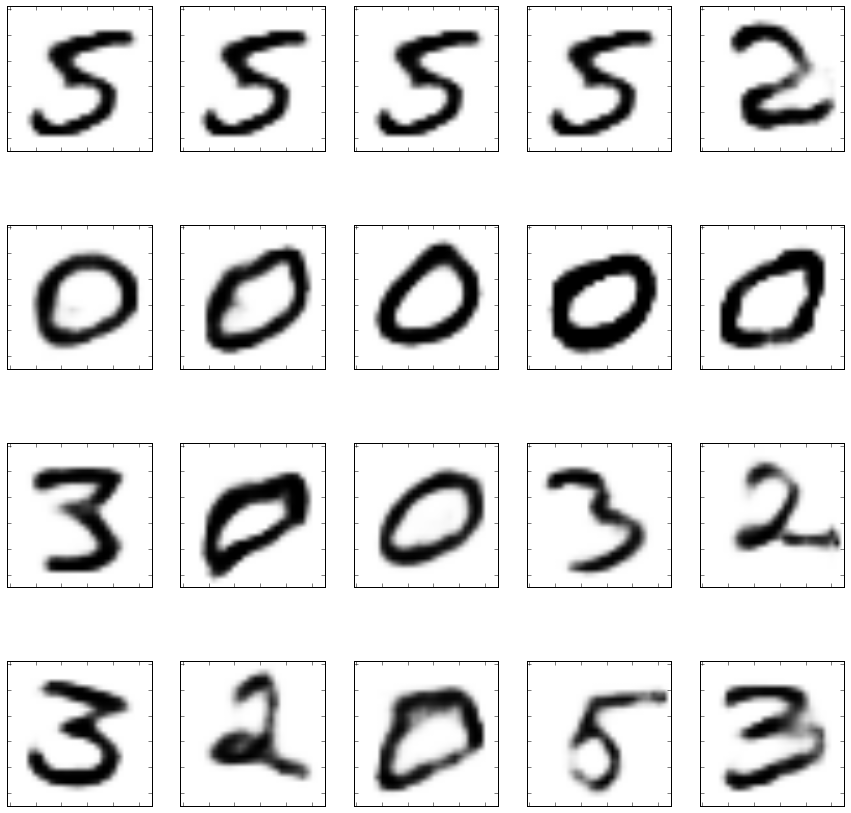

In [10]:
plt.figure(figsize=(15,15))
for i in range(n_show):
    ind = index_list2[i]
    plt.subplot(n_show/5,5,i+1)
    plt.imshow(cuda.to_cpu(x_test_samples[ind].reshape(28,28)),'binary')
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")
    
plt.show()